# Live electrode placement

This notebook is used to position an electrode anywhere you want in the atria, doing possibly analyses with it.

The first blocks define the plotting of the anatomy and the picking of electrode location. Subsequent blocks correspond to different analyses that can be made based on that.

In [1]:
# Load libraries
import os,sys
import numpy as np
import vtk
from vtk.util.numpy_support import numpy_to_vtk,numpy_to_vtkIdTypeArray,vtk_to_numpy
import matplotlib.pyplot as plt
from copy import deepcopy

upperDir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(upperDir,'aux-functions'))
import egm_processing as egmp
import IgbHandling as igb
import quick_visualization as qv
from StandardVTKObjects import EGMColormap
from CatheterObjects import CatheterClass,CatheterGroup
from DirectionTrackingCalculator import VelocityCalculator,VelocityAnalyzer
from SourceTrackingCalculator import SourceTrackingCalculator
from WaveCalculators import WavemapCalculator,WavemapAnalyzer,WaveClassifier

from UserInterfaceFunctions import FancyElectrodePlacementStyle as MouseInteractor
%load_ext autoreload
%autoreload 2


## Load anatomy and select electrode type...

In [2]:
anatomyPath = '/home/vgmarques/data/model-data/anatomy/model30Box'

modelName = 'model24-30Box'
FullCell = igb.LoadCellFile(anatomyPath,modelName,[50,51])
Anatomy,veIndexes = igb.GetDataIndexes(anatomyPath,modelName,FullCell,validCells = [50,51])
scale = 1 # mm

CatheterObj = CatheterClass('HDGrid-4')

### ... Or create your own electrode template

The following templates are available in the CatheterClass:

- HDGrid-4: 4x4 electrode grid, 3 mm spacing in both directions
- Pentaray: 2-6-2 mm spacing per spline, 5 splines (of course)
- Lasso: circle with 10 electrodes. Not sure if is still working as it is an old implementation
- mega: 2 cm x 2 cm patch of 1 mm spaced electrodes in both directions
- mega2: same as mega but with 2 mm spacing
- mega3: same as mega but with 3 mm spacing
___

If you want to create your own template, you can modify the cell below to your needs.
** Do not run this cell if you don't want to create a template as it will mess up with the catheter array **

There are two options: 1) use the template for a grid-like shape or 2) make a generic arrangement

The important part is that you have a ElectrodeTemplate parameter set for the class. Comment the one you are not using

In [2]:
# #1) use the template for a grid-like shape
# # Edit first three lines and 
# CatheterObj.NumberOfElectrodesPerSpline = 4    
# CatheterObj.ElectrodeSpacing = np.ones(CatheterObj.NumberOfElectrodesPerSpline-1)*3 # mm 
# y = np.arange(4)*3 # Number of splines  and spline spacing (mm)

# x = np.arange(self.NumberOfElectrodesPerSpline)*self.ElectrodeSpacing[0] # Number of electrodes  and electrode spacing
# x = x-np.mean(x)
# y = y-np.mean(y)

# grid = np.meshgrid(x,y)
# CatheterObj.ElectrodesTemplate = np.array([grid[0].flatten(),grid[1].flatten()]).T
# CatheterObj.ProjectionFunction = CatheterObj.PlaceCatheter

#2) make a generic arrangement
# Example with lasso. Anything you can create works

r = 10
angles = np.linspace(0,360,r+1)*np.pi/180
x = r*np.cos(angles)
y = r*np.sin(angles) 
# Make template  
CatheterObj.ElectrodesTemplate = np.array([x,y]).T
# Set function to use
CatheterObj.ProjectionFunction = CatheterObj.PlaceCatheter


# Visualization
fig,ax = plt.subplots(1)
ax.scatter(CatheterObj.ElectrodesTemplate[:,0],CatheterObj.ElectrodesTemplate[:,1])

NameError: name 'CatheterObj' is not defined

## Make anatomy actor and interactor

In [3]:
colors = vtk.vtkNamedColors()

try:
    plotData = signal
    cmap = 'egm'
except:
    plotData = np.ones(len(Anatomy))*-5
    cmap = 'heatmap'
# Data
nparray = Anatomy*scale
nCoords = nparray.shape[0]
#
verts = vtk.vtkPoints()
cells = vtk.vtkCellArray()

AnatomyActor,cbarActor,AnatomyData = qv.MakeIgbUnstructuredGridActor(FullCell,[50,51],
                                                                     plotData,smoothFilter=True,cmap=cmap,
                                                                     returnData = True,vmin=-5,vmax=5)
AnatomyActor.GetProperty().SetOpacity(0.9)

In [4]:
# Renderer
renderer = vtk.vtkRenderer()
ren_win = vtk.vtkRenderWindow()
ren_win.SetSize([1400,800])
ren_win.AddRenderer(renderer)
ren_win.SetWindowName('Electrode Positioning')
iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(ren_win)

sphereSource = vtk.vtkSphereSource()
sphereSource.SetRadius(1/5)

try:
    elecSig = np.zeros(len(CatheterObj.ElectrodeIndexes))
    elecSig[0] = 1
    elecSig[3] = 0.5
    ElectrodesActor = qv.MakeGlyphActor(CatheterObj.ElectrodeCoordinates,
                                    np.zeros_like(CatheterObj.ElectrodeCoordinates),magnitudes = elecSig,
                                    vmin=0,vmax=1,
                                    cmap = 'heatmap',source = sphereSource)
    renderer.AddActor(ElectrodesActor)
except:
    print('First placement')


renderer.AddActor(AnatomyActor)
renderer.ResetCamera()
renderer.SetBackground(colors.GetColor3d('White'))

# Add the custom style.
style = MouseInteractor(AnatomyData,verbose=True)
style.SetDefaultRenderer(renderer)

# Add aditional parameters to the function that we passed (TODO: is this bad coding?)
style.Catheter = CatheterObj
style.Anatomy = Anatomy

iren.SetInteractorStyle(style)

ren_win.Render()
iren.Initialize()
iren.Start()

CatheterObj = style.Catheter

First placement
Electrode array center index: 18842
Electrode array center index: 25866
Electrode array center index: 12005
Electrode array center index: 11006
Electrode array center index: 12519


In [11]:
# Manually get catheter in case you want to change anything in the process
CatheterObj = CatheterClass('HDGrid-4')
CatheterObj.GetTissuePatch(18694,style.Anatomy) #BB in RA:9691, 10001
CatheterObj.PlaceCatheter(Anatomy,rotationAngle =0)


## Get the data from the electrode positions

First we need to select a ve file, then getting the data and activation times is straightforward.

This takes a while because the data is pretty large. It also has to be transformed into float after loading.

In [5]:
# Select the ve file
# ve_file = r'D:\\vgmar\model_data\exp915\exp915f04f_ve_egm_endo_epi.igb.gz'
# ve_file = r'D:\\vgmar\model_data\exp906\exp906c72f_ve_egm_endo_epi.igb.gz'
ve_file = '/home/vgmarques/data/model-data/EX0008/forward-solutions/EX0008_FB0_FL200s01f_ve_egm_endo_epi.igb.gz'

# Attention: if you change the electrode position, skip this cell
egmDataAll,hdr = igb.Load(ve_file,returnRawSignal=True) # Workaround for memory issues
egmDataAll = egmDataAll.squeeze()
egmDataAll = egmDataAll[1000:,veIndexes]

{'x': 53254, 'y': 1, 'z': 1, 't': 12000, 'type': 'short', 'architecture': 'lsb', 'facteur': 0.00152593, 'zero': -10.0, 'comments': ['data range = -60.000000 -- 40.000000 mV', 'transparent = 0x0080']}
int16


In [6]:
# Get signal
CatheterObj.GetSignals(egmDataAll[:1000,:],rawInput=True, hdr=hdr)
# Detect activations
CatheterObj.DetectActivations(method = 'adaptiveThreshold')

## Plotting signals: the most basic thing we can do

(<Figure size 720x575 with 2 Axes>,
 <AxesSubplot: xlabel='Position (mm)', ylabel='Position (mm)'>)

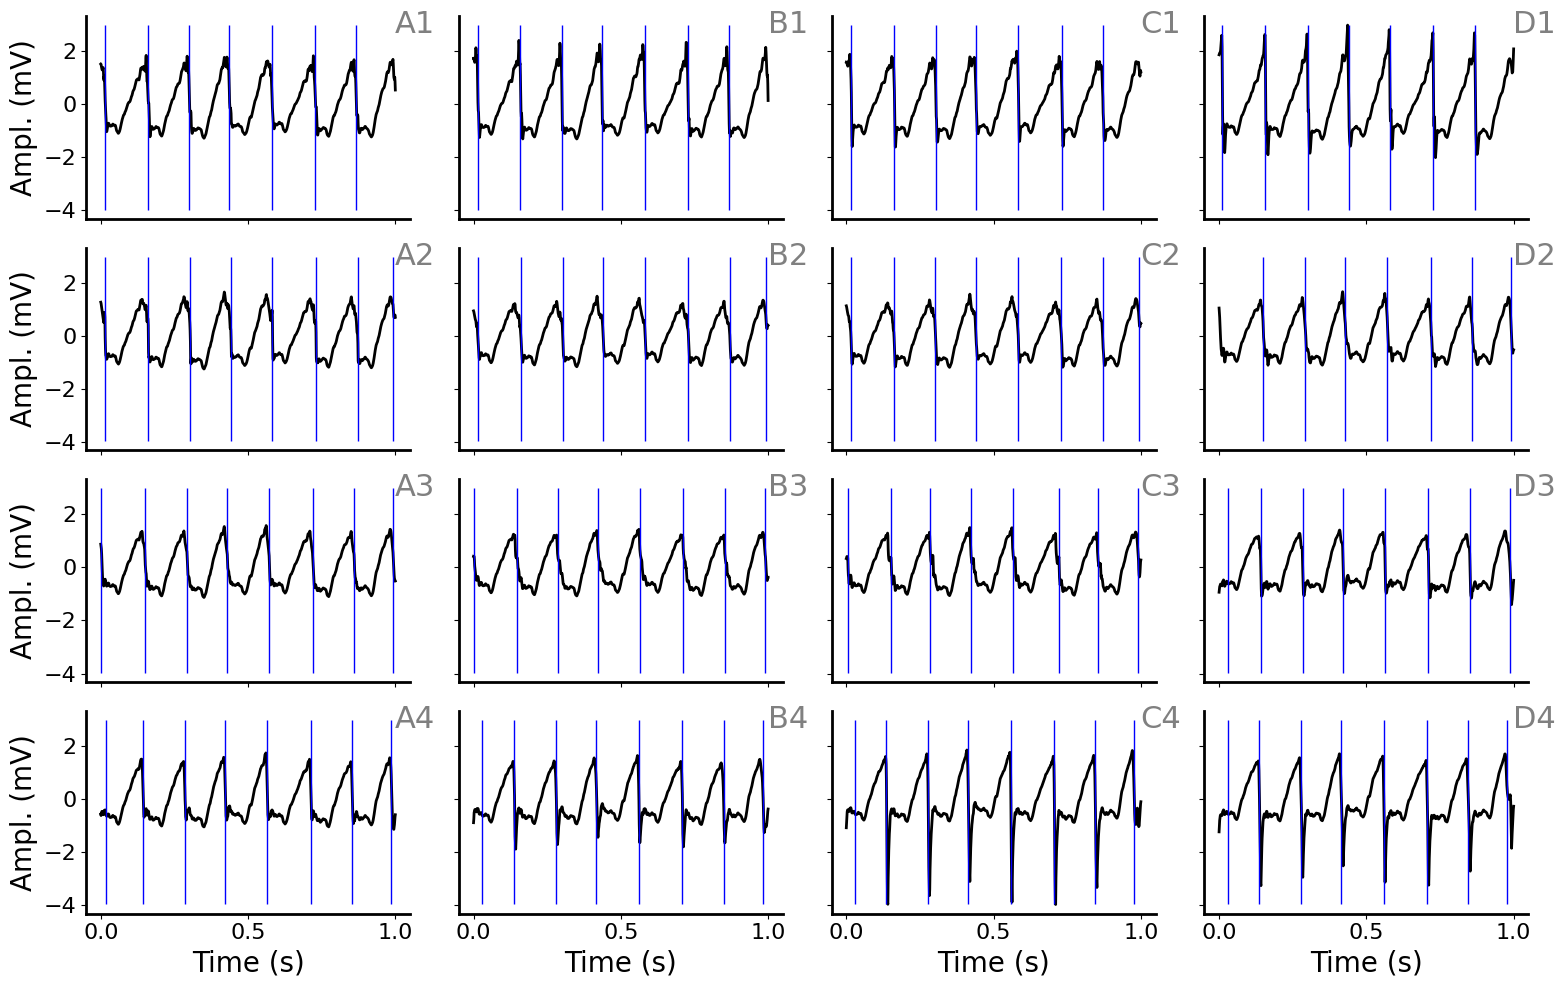

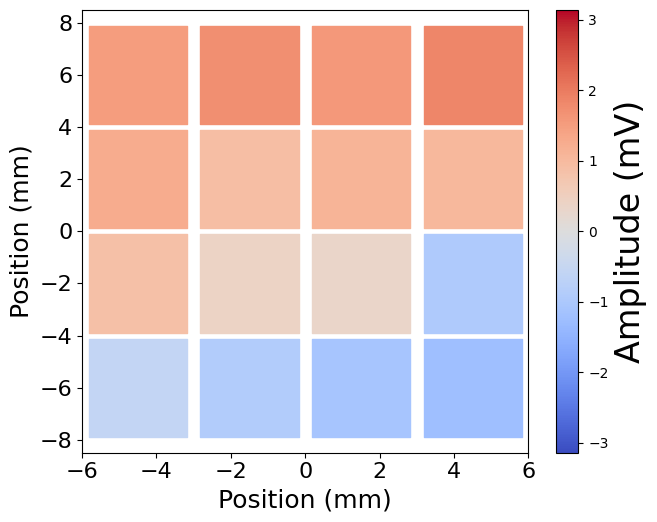

In [7]:
t = 0
qv.HdGridPlot(CatheterObj,t = None,plotActivations = True,plotPhase = False)
qv.HDGridPlot2D(CatheterObj.EGMData,t,colormap='coolwarm',
                cbarLabel='Amplitude (mV)',cbarTicks=None,cbarTickLabels=None)

## Plotting activation phase signals


In [53]:
# Get phase signal
CatheterObj.GetPhaseSignal(activationMethod='adaptiveThreshold',phaseMethod='activation')

In [9]:
# Plot
t = 1134
qv.HdGridPlot(CatheterObj,t = t,
              plotActivations = False,plotPhase = True)

qv.HDGridPlot2D(CatheterObj.PhaseSignal,t,colormap='gnuplot',
                cbarLabel='Phase (rad)',cbarTicks=[-np.pi, 0, np.pi],cbarTickLabels=['$-\pi$', '0', '$+\pi$'])

(<Figure size 720x575 with 2 Axes>,
 <AxesSubplot:xlabel='Position (mm)', ylabel='Position (mm)'>)

In [54]:
qv.Animate2DGrid(CatheterObj.ElectrodesTemplate,CatheterObj.PhaseSignal,
                    0,endFrame=3000,step=5,
                    vmin=-np.pi,vmax=np.pi,
                    colormap='gnuplot',save=True,saveFile=None,
                    cbarLabel='Phase (rad)',cbarTicks=([-np.pi,0,np.pi],[r'$-\pi$','0','$\pi$']))

IndexError: index 1000 is out of bounds for axis 0 with size 1000

## Phase singularity detection

This is done by the 2x2-4x4 rings method.

In [11]:
CatheterObj.GetPhaseSignal(activationMethod='adaptiveThreshold',phaseMethod='sinusoidal')
# Options for phaseMethod are 'activation' and 'sinusoidal'

In [15]:
from SourceTrackingCalculator import SourceTrackingCalculator
STC = SourceTrackingCalculator(1.5*np.pi)
STC.DoubleRingPSDetection(CatheterObj)

Nr,Nc = CatheterObj.GetGridSize()
xi,yi = CatheterObj.ElectrodesTemplate[:,0],CatheterObj.ElectrodesTemplate[:,1]

PercentageSPs = np.sum(STC.PSLocations,axis=0)/CatheterObj.GetNumberOfSamples()*100
xp,yp = STC.PSAxis[:,0],STC.PSAxis[:,1]


fig,ax = plt.subplots(1)
cax = ax.pcolormesh(yp,xp,PercentageSPs.T,shading='nearest',cmap = 'jet',vmin=0)
ax.scatter(yi,xi,c = 'w',edgecolor='k')
ax.set_aspect('equal')
ax.set_xlim([yi[0]-.25,yi[-1]+.25])
ax.set_ylim([xi[0]-.25,xi[-1]+.25])
ax.set_xlabel('Position (mm)',fontsize=16)
ax.set_ylabel('Position (mm)',fontsize=16)
cbar = fig.colorbar(cax)
cbar.set_label('% of time with PSs',fontsize=16)

CatheterObj.CatheterCenterIndex

19094

In [16]:
from matplotlib import animation
# Video
signal = CatheterObj.PhaseSignal
endFrame=3000
colormap=None
vmin=-np.pi
vmax=np.pi
xi,yi = CatheterObj.GetGridPositions()
gridLocations = np.meshgrid(xi,yi)
trueShape = (-1,len(yi),len(xi))

signal = np.reshape(signal,trueShape)

initialFrame=0
step=10
cbarTicks = ([-np.pi,0,np.pi],['$-\pi$','0','$\pi$'])
cbarLabel = 'Phase' 

if endFrame==-1: endFrame = signal.shape[0]
if colormap is None: colormap = 'gnuplot' 
if vmin is None: vmin=np.nanmin(signal)
if vmax is None: vmax=np.nanmax(signal)
signal[np.isnan(signal)] = vmin

sampleSteps = np.arange(initialFrame,endFrame,step,dtype=int)
nFrames = sampleSteps//step

fig, ax = plt.subplots(1,figsize=(7.2,5.75))

vUnique = np.unique(gridLocations[1])
vSpace = np.abs(vUnique[1]-vUnique[0])
hSpace = np.abs(xi[1]-xi[0])

ax.set(xlim=(yi[0]-vSpace/2,yi[-1]+vSpace/2), 
        ylim=(xi[0]-hSpace/2,xi[-1]+hSpace/2))

ax.set_xlabel('Position (mm)',fontsize = 18)
ax.set_ylabel('Position (mm)',fontsize = 18)
ax.tick_params(labelsize=16)
ax.set_aspect('equal')

cax = ax.pcolormesh(gridLocations[1],gridLocations[0],
                signal[sampleSteps[0],:,:],
                    cmap = colormap,
                #marker='s',s=5000,
                vmin = vmin,vmax = vmax,shading='nearest')

xp,yp = np.where(STC.PSLocations[sampleSteps[0],:,:].T!=0)

spax = ax.scatter(STC.PSAxis[yp,1],STC.PSAxis[xp,0],color='w',edgecolor='k',s=250)

if cbarTicks is not None:
    cbar = fig.colorbar(cax, ticks = cbarTicks[0],ax = ax)
    cbar.ax.set_yticklabels(cbarTicks[1], fontsize = 24) 
else:  
    cbar = fig.colorbar(cax,ax = ax) 
if cbarLabel is not None: 
    cbar.set_label(cbarLabel, fontsize = 24)


fig.suptitle('t= %d ms'%(sampleSteps[0]), fontsize = 28)

def animSP(i,signal,STC):
    cax.set_array(signal[i,:,:]) # https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolormesh_grids.html
    xp,yp = np.where(STC.PSLocations[i,:,:].T!=0)
    points = np.asarray([STC.PSAxis[yp,1],STC.PSAxis[xp,0]]).T    
    spax.set_offsets(points) 
    
    fig.suptitle('t= %d ms'%(i), fontsize = 28)
    return fig

anim = animation.FuncAnimation(fig, animSP, interval = 60, frames=sampleSteps,
                        repeat_delay = 200,fargs=(signal,STC))

if 1:
    writer = animation.FFMpegWriter(fps = 10)
    anim.save('output_video.mp4', writer=writer)
else:
    plt.show()

## Preferentiality

As calculated from the differences in activation time within activation time groups.

Planar waves yield high preferentiality, whereas rotors give lower values. Slow conduction velocity areas also gives lower values

In [16]:
# Group activation times based on a conduction velocity threshold
# Use Stef's algorithm to select valid activations before grouping
vCalc = VelocityCalculator()
vCalc.NormalConductionThreshold = 0.2
vAnalyzer = VelocityAnalyzer()

allActivations,allPositions,allElectrodeIndices = vCalc.AdjustSignalsCV(CatheterObj)
actGroups = vCalc.GroupValidActivations(allActivations,allPositions,allElectrodeIndices)
groupBegin = np.array(list(actGroups.keys()))

In [17]:
allActivations,allPositions,allElectrodeIndices = vCalc.AdjustSignalsCV(CatheterObj,useRealPositions=True)
xVelocity, yVelocity = vCalc.Compute2DActivationWavefront(allActivations, allPositions)
ConductionVelocity = vCalc.MakeCVDict(allActivations,allElectrodeIndices,xVelocity,yVelocity)
intervalPreferentiality = vAnalyzer.AnalyzeVelocity([0,1000],ConductionVelocity)

# Calculate variance of angles
DirectionalPreferentiality = STC.ComputeDirectionalPreferentiality(intervalPreferentiality)
Velocities3D = vAnalyzer.ComputeMeanVelocityV2(intervalPreferentiality,vCalc)

In [19]:

fig, ax = plt.subplots()
cir = plt.Circle((0,0), 1, color='b',fill=False)
ax.set_aspect('equal')
ax.add_patch(cir)

ax.plot([0],[0],'b.')
ax.plot([1,-1],[0,0],'b.',marker='_',markersize=10)
ax.plot([0,0],[1,-1],'b.',marker='|',markersize=10)

ax.axis('off')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

C:\Users\vgmar\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  import sys
C:\Users\vgmar\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  


(-1.1, 1.1)

## Calculate recurrence plots

In [10]:
sys.path.append(os.path.join(upperDir,'recurrence'))
from RecurrenceComputation import RecurrenceComputation

# Calculate distance matrices

recComp = RecurrenceComputation()
recComp.SampleShift = 5
recComp.TheilerAFCLNumber = 0.5
recComp.ExpectedAFRecurrenceRate = 1

# This takes a while, maybe can improve to cut a piece of the signals
distanceMatrix, _, activationCycleLength  = \
            recComp.ComputeDistanceMatrix(CatheterObj, CatheterObj.Activations)
estimatedAFCL = np.median(activationCycleLength)

In [11]:
# Calculate recurrence plots
RPThreshold = 0.15
timeInterval = np.array([0,10000])//recComp.SampleShift
partDM = distanceMatrix[timeInterval[0]:timeInterval[1],:][:,timeInterval[0]:timeInterval[1]]
RP, recurrenceTime, recurrenceThreshold, partDM = \
                    recComp.ComputeRecurrencePlot(partDM, 1000, estimatedAFCL,recurrenceThreshold= RPThreshold)
RP = recComp.ErodeRP(RP,distanceMatrix=partDM,linear=True)


In [41]:
fi,ax = plt.subplots(1,figsize = [11.25,10.25])
xi,yi = np.where(RP)
ax.scatter(recurrenceTime[xi],recurrenceTime[yi],color='k',s=.005)
ax.set_xlabel('Time (s)',fontsize = 18)
ax.set_ylabel('Time (s)',fontsize = 18)
ax.tick_params(labelsize=18)
axTime = np.unique(np.round(recurrenceTime,1))
ax.set_xticks(axTime[::20])
ax.set_yticks(axTime[::20])
ax.set_xlim([axTime[0],axTime[-1]])
ax.set_ylim([axTime[0],axTime[-1]])
recurrence_rate = len(xi)/(RP.shape[0]**2)*(estimatedAFCL/recComp.SampleShift)
fi.suptitle('RR=%0.3f'%recurrence_rate,fontsize = 20)
fi.tight_layout()

## Conduction velocity and preferentiality

In [104]:
# Make classes and adjust data
vCalc = VelocityCalculator()
vCalc.Radius = 2 * np.sqrt(3**2+4**2)

vAnalyzer = VelocityAnalyzer()

# Run slow functions
allActivations,allPositions,allElectrodeIndices = vCalc.AdjustSignalsCV(CatheterObj)
xVelocity, yVelocity = vCalc.Compute2DActivationWavefront(allActivations, allPositions)
ConductionVelocity = vCalc.MakeCVDict(allActivations,allElectrodeIndices,xVelocity,yVelocity)

In [26]:
# Run remaining functions
timeInterval = [0,1000]
intervalPreferentiality = vAnalyzer.AnalyzeVelocity([timeInterval[0],timeInterval[1]],ConductionVelocity)
qv.PlotConductionVelocity(CatheterObj,intervalPreferentiality,pointOrigin=False)

In [29]:
# qv.PlotConductionVelocity(CatheterObj,intervalPreferentiality,pointOrigin=False)
qv.PlotPreferentiality(CatheterObj,intervalPreferentiality,pointOrigin=False)


In [28]:
intervalPreferentiality['value'].mean()

0.9937699117548892

## Isochrones

In [46]:
activationGroups = egmp.GroupActivations(CatheterObj.Activations,longestElectrodeAxis = 20,cvThreshold =0.1)

xi,yi = CatheterObj.GetGridPositions()
nCols = int(np.ceil(np.sqrt(len(activationGroups))))
 
fig,ax = plt.subplots(nCols,nCols,figsize=(12,12),sharex=True,sharey=True)

xi,yi = CatheterObj.GetGridPositions()
for i,key in enumerate(activationGroups):
    data = activationGroups[key].astype(float).reshape(CatheterObj.GetGridSize()).T
    data[data==-1] = np.nan
    data = egmp.Norm2Vals(data,[0,1])
    cax = ax[i//nCols,i%nCols].pcolor(yi,xi,data,shading = 'nearest',vmin=0,vmax = 1)
    ax[i//nCols,i%nCols].axis('off')
    ax[i//nCols,i%nCols].set_aspect('equal')
    ax[i//nCols,i%nCols].set_title(key)

# fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cbarax = plt.axes([0.85, 0.1, 0.015, 0.8])
# cbar = fig.colorbar(cax,cax=cbarax,ticks=[0,1])
# cbar.set_label(label='Activation',fontsize=18)
# cbar.ax.set_yticklabels(['Early', 'Late'])
# cbar.ax.tick_params(labelsize=16)

In [78]:
key = 290 #8,129,290
fig,ax = plt.subplots(1,figsize=(8,8))
data = activationGroups[key].astype(float).reshape(CatheterObj.GetGridSize()).T
data[data==-1] = np.nan
data -= np.nanmin(data)
cax = ax.pcolor(yi,xi,data,shading='nearest')
ax.set_xlabel('Electrode position (mm)',fontsize=16)
ax.set_ylabel('Electrode position (mm)',fontsize=16)
ax.tick_params(labelsize=16)
cbar = fig.colorbar(cax)
cbar.set_label(label='Activation time (ms)',fontsize=16)
cbar.ax.tick_params(labelsize=16)
# cbar.ax.set_yticks([0,1])
# cbar.ax.set_yticklabels(['Early', 'Late'])
# cbar.ax.tick_params(labelsize=16)

In [79]:
# Same as above but with CV values

fig,ax = plt.subplots(1,figsize=(8,8))
cax = ax.pcolor(yi,xi,data,shading='nearest')

xx,yy = np.meshgrid(xi,yi)
ax.quiver(yy,xx,yVelocity[activationGroups[key]],xVelocity[activationGroups[key]],color = 'w',scale=3,width = .01)

ax.quiver(0,0,np.mean(yVelocity[activationGroups[key]]),np.mean(xVelocity[activationGroups[key]]),
          color = 'r',scale=0.5,width = .03,pivot='mid')


ax.set_xlabel('Electrode position (mm)',fontsize=16)
ax.set_ylabel('Electrode position (mm)',fontsize=16)
ax.tick_params(labelsize=16)
cbar = fig.colorbar(cax)
cbar.set_label(label='Activation time (ms)',fontsize=16)
cbar.ax.tick_params(labelsize=16)



## Wave Calculations

In [55]:
wCalc = WavemapCalculator()
wCalc.NeighborRadius = np.sqrt(2**2+3**2)#*1.05
wCalc.ConductionThreshold = 0.1 # mm/ms
electrodeNeighbors = [[0,1,4,5],[0,1,2,4,5,6],[1,2,3,5,6,7],[2,3,6,7],
                      [0,1,4,5,8,9],[0,1,2,4,5,6,8,9,10],[1,2,3,5,6,7,9,10,11],[2,3,6,7,10,11],
                      [4,5,8,9,12,13],[4,5,6,8,9,10,12,13,14],[5,6,7,9,10,11,13,14,15],[6,7,10,11,14,15],
                      [8,9,12,13],[8,9,10,12,13,14],[9,10,11,13,14,15],[10,11,14,15]]
wCalc.NeighborList = electrodeNeighbors
minimumDuration = 0 #ms

reentryThresholds = {'MaxCurvatureScores':0.4,'CLCoverage':0.1}
focalThresholds = {'NumberOfTrajectories':2,'MinAngles':0.314,
                    'MaxAngles':1.257,'CLCoverage':0.1,
                    'DirectionalPreferentiality':0.7}

In [56]:
activationGroups = egmp.GroupActivations(CatheterObj.Activations,longestElectrodeAxis = 30,cvThreshold =wCalc.ConductionThreshold)
waves = wCalc.DetectConnectedActivations(CatheterObj,activationGroups)
waves = wCalc.RemoveSmallWaves(waves,minimumWaveSize = 8)
wAnalyzer = WavemapAnalyzer(waves,wCalc.ConductionThreshold,wCalc.NeighborRadius)
wAnalyzer.MinimumDuration = minimumDuration
wAnalyzer.ComputeAllAnalyses()

D:\vgmar\Documents\GitHub\USI\model-analyses\aux-functions\WaveCalculators.py:945: RuntimeWarning: divide by zero encountered in true_divide
  conductionMatrix = distanceMatrix / activationDifferenceMatrix
D:\vgmar\Documents\GitHub\USI\model-analyses\aux-functions\WaveCalculators.py:945: RuntimeWarning: invalid value encountered in true_divide
  conductionMatrix = distanceMatrix / activationDifferenceMatrix


In [58]:
for waveIndex in wAnalyzer.Waves.keys():
    wAnalyzer.PlotWaveAndTrajectories(waveIndex,'2d')

    

In [26]:
fig = plt.gcf()
ax = plt.gca()
ax.set_xlabel('Electrode Position (mm)',fontsize=16)
ax.set_ylabel('Electrode Position (mm)',fontsize=16)

fig.figsize=(8,8)

## Snapshot of the ve file

In [74]:
t = 10500
nz,ny,nx = FullCell.shape
linearInds = igb.Coord2Idx(Anatomy,(nx,ny,nz))
rearrangeInds = np.argsort(linearInds)

signal = egmDataAll[t,:]*hdr['facteur']+hdr['zero']
signal = signal[rearrangeInds].reshape(-1,1)


AnatomyActor,cbarActor,AnatomyData = qv.MakeIgbUnstructuredGridActor(FullCell,[50,51],
                                                                     signal,smoothFilter=True,cmap='egm',
                                                                     returnData = True,vmin=-5,vmax=5)
AnatomyActor.GetProperty().SetOpacity(0.9)
elecSig = np.zeros(len(CatheterObj.ElectrodeIndexes))
elecSig[0] = 1
elecSig[3] = 0.5

ElectrodesActor,_ = qv.MakePolyDataActor(Anatomy[CatheterObj.ElectrodeIndexes,:],elecSig.reshape(1,-1),cmap = 'heatmap')
ElectrodesActor.GetProperty().SetRenderPointsAsSpheres(1)
ElectrodesActor.GetProperty().SetPointSize(20)

qv.QuickRenderWindowInteractor([AnatomyActor,ElectrodesActor],[cbarActor])

## Heatmap
For that, the PSs need to be detected with the dedicated algorithms

**TODO**

In [75]:
test = np.array([8624, 8624, 8638, 8623, 8624, 8624])
test = Anatomy[test,:]
testActor = qv.MakeGlyphActor(test,np.zeros_like(test),source = 'sphere')

qv.QuickRenderWindowInteractor([AnatomyActor,ElectrodesActor,testActor],[cbarActor])